Importing packages

In [1]:
#Importing Packages.
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2

In [2]:
#Loading the image files yes to the tumor array.
tumor=[]
path='./Testing/yes/*.jpg'
for i in glob.iglob(path):
    img=cv2.imread(i)
    img=cv2.resize(img,(128,128))#Changing the shapes of the images for consistency img reading
    b , g, r=cv2.split(img)
    img=cv2.merge([r,g,b])
    tumor.append(img)

In [3]:
#Loading of non tumor image files to the array.
no_tumor=[]
path2='./Testing/no_tumor/*.jpg'
for i in glob.iglob(path2):
    img=cv2.imread(i)
    img=cv2.resize(img,(128,128))#Changing the shapes of the images for consistency img reading
    b , g, r=cv2.split(img)
    img=cv2.merge([r,g,b])
    no_tumor.append(img)

In [4]:
no_tumor=np.array(no_tumor)
tumor=np.array(tumor)
All=np.concatenate((no_tumor,tumor))

Visualizing 

In [31]:
def plot_random(no_tumor,tumor,num=5):
    nti=no_tumor[np.random.choice(no_tumor.shape[0], num, replace=False)]
    ti=tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('Tumorfree')
        plt.imshow(nti[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('Tumor')
        plt.imshow(ti[i])

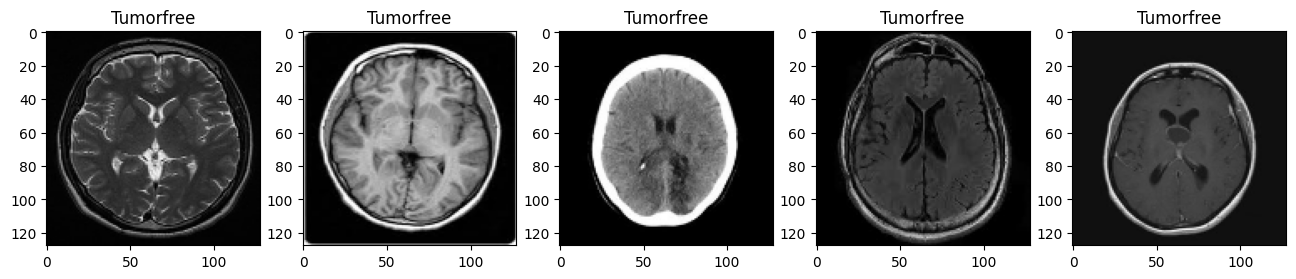

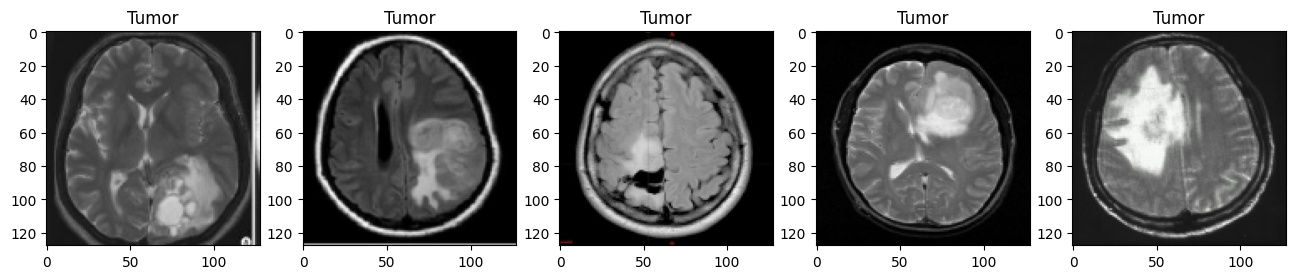

In [36]:
plot_random(no_tumor,tumor,num =5)